In [1]:
%matplotlib widget

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import time

Rosenbrock function

$f(x,y) = (a-x)^2 + b (y-x^2)^2$ 


In [3]:
a = 1
b = 100

def rosenbrock(x,y, a=a,b=b):
    return (a-x)**2 + b* (y-x**2)**2

In [4]:
class Solution:
    def __init__(self,x ,y)-> None:
        self.x = [x]
        self.y = [y]
        self.f = [rosenbrock(x,y)]
        self.nablaf = []
        self.nt = []
        self.deltas = []

    def getX(self):
        return np.array([self.x[-1], self.y[-1]])
    
    def getVal(self):
        return self.f[-1]

    def getPreVal(self):
        return self.f[-2]

    def setVal(self, x, y):
        self.x.append(x)
        self.y.append(y)
        self.f.append(rosenbrock(x,y))

In [5]:
# initial condition
x0 = 2
y0 = -25
sol = Solution(x0,y0)
sol_newton = Solution(x0,y0)

# newton tr settings 
damping = 1
max_iter = 100
tol = 1e-10
delta_0 = 0.2
eta_1 = 0.001
eta_2 = 0.25
eta_3 = 0.75
t1 = 0.25
t2 = 2.0
delta_tol = 1e-12

In [6]:
def F(solution):
    x = solution.x[-1]
    y = solution.y[-1]
    R = [a-x, np.sqrt(b)*(y-x**2)]
    return np.matrix(R).transpose()

In [7]:
def JF(solution):
    x = solution.x[-1]
    y = solution.y[-1]
    J = np.matrix(np.zeros((2,2)))
    J[0,0] = -1
    J[0,1] = 0
    J[1,1] = np.sqrt(b)
    J[1,0] = -np.sqrt(b)*2*x
    return J

In [8]:
def f(solution):
    return 0.5 * np.linalg.norm(F(solution))**2

In [9]:
def alpha(delta, nablaf, J):
    alpha_0 = delta/np.linalg.norm(nablaf)
    alpha_1 = np.linalg.norm(nablaf)**2 / np.matmul(
                           nablaf.transpose(), np.matmul(
                           np.matmul(J.transpose(), J), nablaf))[0,0]
    return np.min([alpha_0, alpha_1])

In [10]:
def tau(delta, s_nt, s_cy):
    p_0 = np.matmul((s_nt-s_cy).transpose(), s_nt-s_cy)
    p_1 = np.matmul(2*s_cy.transpose(), s_nt-s_cy)
    p_2 = np.matmul(s_cy.transpose(), s_cy) - delta**2
    assert p_0.shape == (1, 1)
    assert p_1.shape == (1, 1)
    assert p_2.shape == (1, 1)
    taupm = np.roots([p_0[0,0], p_1[0,0], p_2[0,0]])
    tau = np.max(taupm)
    return tau

In [11]:
def rho(R, J, p, sol_temp):
    f0 = 0.5 * np.matmul(R.transpose(), R)[0,0]
    gn = np.matmul(J.transpose(),R)
    Bn = np.matmul(J.transpose(),J)
    g = 0.5 * np.linalg.norm(F(sol_temp))**2
    mp = f0 + np.matmul(gn.transpose(), p)[0,0] + 0.5 * np.matmul(p.transpose(), np.matmul(Bn,p))[0,0]
    print(f"f0-g: {f0-g} f0-mp: {f0-mp}")
    return (f0 - g )/(f0-mp)

## TRDC

In [12]:
niter = 0
error = 9e9
xnorm = np.linalg.norm(sol.getX())
delta = delta_0 * xnorm

while ((error > tol) and (niter <= max_iter)):   
    J = JF(sol)       
    R = F(sol) 
    s_nt = np.matrix(linalg.solve(J, -R))
    #scale s, delta
    nablaf =  np.matmul(J.transpose(), R)
    norms_nt = np.linalg.norm(s_nt)
    #print(f"Debug Newton update: {s_nt}")
    inner_iter = 0
    while True:
        inner_iter = inner_iter +1
        print(f"\n inner iter {inner_iter} \n")
        if norms_nt <= delta:
            print(f"newton step in TR: newtonnorm: {norms_nt}, TR: {delta}")
            sn = s_nt
        else:
            s_cy = - alpha(delta, nablaf, J) * nablaf
            norms_cy = np.linalg.norm(s_cy)
            print(f"angle between s_nt and s_cy: {np.arccos((s_cy.transpose()*s_nt)[0,0]/( norms_nt*norms_cy))/3.14159265359*180.0}")
            #print(f"Debug Cauchy update: {s_nt}")
            if np.linalg.norm(s_cy) > delta:
                print(f"cauchy step not in TR: cauchynorm: {s_cy}, TR {delta}")
                sn = s_cy
            else:
                print(f"dogleg step: tau: {tau(delta, s_nt, s_cy)}")
                sn = s_cy + tau(delta, s_nt, s_cy) * (s_nt-s_cy)
                print(f"check sn {np.linalg.norm(sn)}, delta: {delta}")
        sol_temp = Solution(sol.x[-1],sol.y[-1])

        sol_temp.setVal(sol.x[-1]+sn[0,0],sol.y[-1]+sn[1,0])
        rho_ = rho(R, J, sn, sol_temp)
        print("rho:", rho_)
        #rescale sn, delta
        #precheck
        #print(f"Debug residual: {R}")
        #print(f"Debug Jacobian: {J}")  
        #print(f"Debug update: {sn}")
        if rho_ < eta_2:
            print("rho too small, decrease trust radius")
            delta = t1 * delta
        elif rho_ > eta_3:
            print("rho too big, increase trust radius")
            delta = t2 * delta
        print("trust radius:", delta)
        if rho_ > eta_1:
            print("improvement satisfying")
            break
        elif delta < delta_tol:
            print("trust radius smaller than delta_tol")
            raise RuntimeError("opti failed")
    sol.setVal(sol.x[-1]+sn[0,0],sol.y[-1]+sn[1,0])
    sol.nablaf.append(-alpha(delta, nablaf, J) * nablaf)
    sol.nt.append(s_nt)
    sol.deltas.append(delta)
    error = np.linalg.norm(F(sol))
    niter = niter + 1
    print(f"\n # Iteration {niter}: error: {error} tol: {tol} \n")
                


 inner iter 1 

angle between s_nt and s_cy: 73.67430858133963
dogleg step: tau: -1.7557131829239675e-16
check sn 5.015974481593782, delta: 5.015974481593782
f0-g: -9153.286063441796 f0-mp: 38583.064659832744
rho: -0.2372358480110811
rho too small, decrease trust radius
trust radius: 1.2539936203984454

 inner iter 2 

angle between s_nt and s_cy: 73.67430858133963
dogleg step: tau: -1.5319982265479827e-17
check sn 1.2539936203984454, delta: 1.2539936203984454
f0-g: 10021.514726343983 f0-mp: 13657.861185821163
rho: 0.7337543258052561
trust radius: 1.2539936203984454
improvement satisfying

 # Iteration 1: error: 253.09676123433906 tol: 1e-10 


 inner iter 1 

angle between s_nt and s_cy: 57.93590584421177
dogleg step: tau: -7.161454813725907e-18
check sn 1.2539936203984454, delta: 1.2539936203984454
f0-g: 2997.0913986519336 f0-mp: 5627.029003455653
rho: 0.5326241248821304
trust radius: 1.2539936203984454
improvement satisfying

 # Iteration 2: error: 240.9642872917233 tol: 1e-10 


 

## Newton only:

In [13]:
niter = 0
error = 9e9

while ((error > tol) and (niter <= max_iter)):   
    J = JF(sol_newton)       
    R = F(sol_newton) 
    s_nt = np.matrix(linalg.solve(J, -R))
    norms_nt = np.linalg.norm(s_nt)
    sol_newton.setVal(sol_newton.x[-1]+s_nt[0,0],sol_newton.y[-1]+s_nt[1,0])
    sol_newton.nt.append(s_nt)
    error = np.linalg.norm(F(sol_newton))
    niter = niter + 1
    print(f"\n # Iteration {niter}: error: {error} tol: {tol} \n")


 # Iteration 1: error: 10.0 tol: 1e-10 


 # Iteration 2: error: 0.0 tol: 1e-10 



In [20]:
#sol.deltas

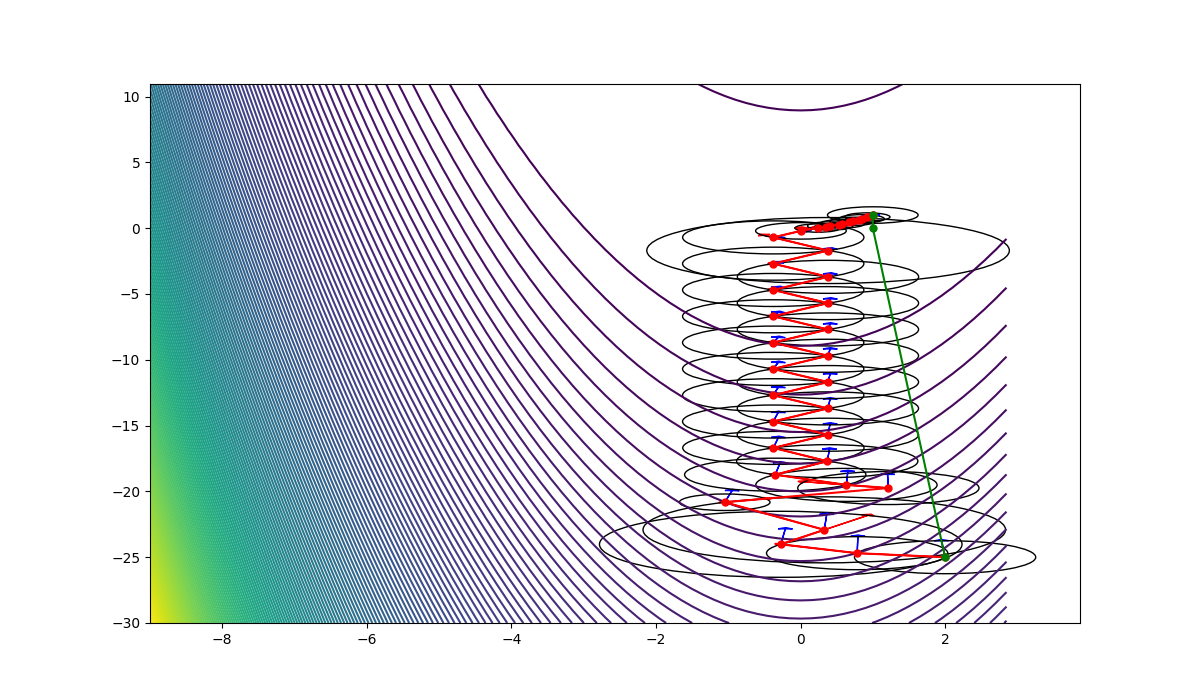

In [15]:
plt.figure(figsize=(12, 7))

# red lines/points: TRDC trajectory
# red arrows: cauchy direction
# blue arrows: newton direction
# green lines/points newton tractory
# black circles: trust radii

X = np.arange(-9, 3, 0.15)
Y = np.arange(-30, 11, 0.15)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X,Y)

plt.contour(X,Y,Z,200)

ax = plt.gca()
plt.plot(sol.x,sol.y,marker='o',markersize=5, color ='r')
plt.plot(sol_newton.x,sol_newton.y,marker='o',markersize=5, color ='g')
circles = []
for i in range(len(sol.nablaf)):
    plt.arrow(sol.x[i],sol.y[i],sol.nablaf[i][0,0],sol.nablaf[i][1,0], head_width=0.2, head_length=0.1, fc='r', ec='r')
    plt.arrow(sol.x[i],sol.y[i],sol.nt[i][0,0]/20,sol.nt[i][1,0]/20, head_width=0.2, head_length=0.1, fc='b', ec='b')
    circles.append(plt.Circle((sol.x[i], sol.y[i]), sol.deltas[i], color='k', fill=False))
    ax.add_patch(circles[-1])

## Newton flow

In [16]:
def res(x, y):
    R = [a-x, np.sqrt(b)*(y-x**2)]
    return np.matrix(R).transpose()

In [17]:
def jac(x,y):
    J = np.matrix(np.zeros((2,2)))
    J[0,0] = -1
    J[0,1] = 0
    J[1,1] = np.sqrt(b)
    J[1,0] = -np.sqrt(b)*2*x
    return J

In [18]:
X = np.arange(-9, 3, 0.15)
Y = np.arange(-30, 11, 0.15)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X,Y)

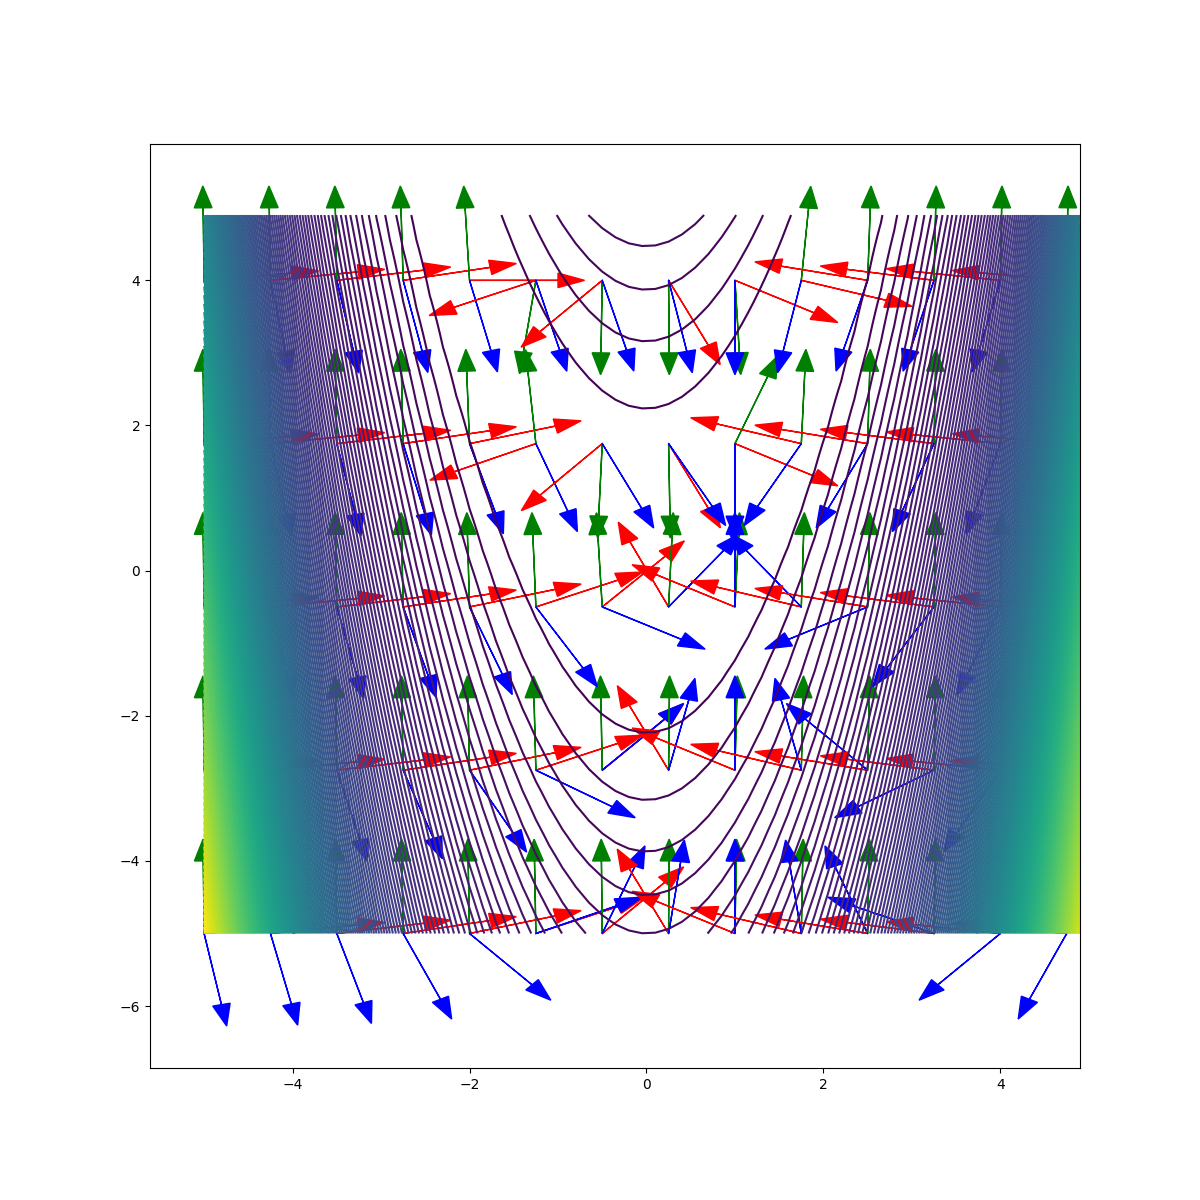

In [37]:
plt.figure(figsize=(12, 12))

# red lines/points: TRDC trajectory
# red arrows: cauchy direction
# blue arrows: newton direction
# green lines/points newton tractory
# black circles: trust radii

X = np.arange(-5, 5, 0.15)
Y = np.arange(-5, 5, 0.15)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X,Y)

plt.contour(X,Y,Z,200)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if i % 15 == 0 and j % 5 ==0:
            r = res(X[i,j], Y[i,j])
            J = jac(X[i,j], Y[i,j])
            s_nt = np.matrix(linalg.solve(J, -r))
            s_cy =  -np.matmul(J.transpose(), r)
            s_cy = s_cy / np.linalg.norm(s_cy)
            s_sd = -np.matmul(J, np.matrix([X[i,j], Y[i,j]]).transpose())
            s_sd = s_sd / np.linalg.norm(s_sd)
            plt.arrow(X[i,j],Y[i,j],s_cy[0,0], s_cy[1,0], head_width=0.2, head_length=0.3, fc='r', ec='r')
            plt.arrow(X[i,j],Y[i,j],s_sd[0,0], s_sd[1,0], head_width=0.2, head_length=0.3, fc='g', ec='g')
            plt.arrow(X[i,j],Y[i,j],1*s_nt[0,0]/np.linalg.norm(s_nt), s_nt[1,0]/np.linalg.norm(s_nt), head_width=0.2, head_length=0.3, fc='b', ec='b')